# Previsão do desempenho (nota geral) do candidato
- Neste notebook, será realizada uma tarefa de regressão, que consiste na previsão da nota geral do candidato (target) com base nas variáveis que vimos na análise exploratória de dados. Será aplicado o aprendizado supervisionado, com um conjunto de dados rotulado e um target contínuo.
- O objetivo consiste de construir um modelo de machine learning capaz de prever acuradamente a nota geral do candidato. Além disso, avaliar quais variáveis independentes impactam mais e menos a nota.
- Para isso, técnicas de limpeza e pré-processamento de dados (feature engineering), treinamento (seleção de features, comparação com validação cruzada, seleção, tunagem de hiperparâmetros) e validação de modelos de machine learning (avaliação de métricas em conjunto de testes) serão aplicadas.
- Todo esse processo será baseado no framework CRISP-DM, podendo envolver ciclos de pré-processamento e validação de modelos repetidamente.
- Pipeline de modelagem:
    - Divisão dos dados em treino, teste e validação.
    - Limpeza e pré-processamento dos dados.
    - Comparação e seleção de modelo potencial com validação cruzada k-fold.
    - Seleção de features.
    - Tunagem de hiperparâmetros.
    - Avaliação final no conjunto de testes (simulando o ambiente de produção).
    - Deploy.

#### 1. Importando as bibliotecas

In [25]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

#### 2. Coletando os dados
- Considerando que estamos tentando prever o desempenho do candidato na prova, serão incluídos na modelagem apenas dados de estudantes que compareceram em ambos os dias de prova, como visto na Análise de Desempenho no notebook '2_eda.ipynb'. Dessa forma, evitamos distorções e assimetrias, afinal, alunos que não comparecem ficam com nota nula.

In [43]:
# Reading the memory optimized data.
path = 'D:\\MLProjects\\DadosENEM\\clean_df.parquet'
df = pd.read_parquet(path)

# Selecting only students who were present in both the days of the exam.
df = df.loc[(df['presenca_lc'] == 'Presente') & (df['presenca_ch'] == 'Presente') 
            & (df['presenca_cn'] == 'Presente') & (df['presenca_mt'] == 'Presente')].reset_index(drop=True)

#### 2.1 Rápida visualização e informações gerais

In [21]:
df.head()

,faixa_etaria,sexo,estado_civil,status_conclusao_ensino_medio,escola,treineiro,municipio_prova,uf_prova,presenca_cn,presenca_ch,...,nota_comp3,nota_comp4,nota_comp5,nota_redacao,escolaridade_pai,escolaridade_mae,renda_familiar_mensal,possui_celular_em_casa,possui_computador_em_casa,acesso_internet_em_casa
0,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Presidente Tancredo Neves,BA,Presente,Presente,...,120.0,140.0,160.0,760.0,Ensino médio completo,Ensino superior completo,"Até R$ 1.212,00",Dois ou mais,Não,Sim
1,Jovem adulto (18-24),M,Solteiro(a),Concluído,Não respondeu,Não,Cariacica,ES,Presente,Presente,...,40.0,100.0,20.0,320.0,Ensino fundamental incompleto,Nunca estudou,Nenhuma Renda,Dois ou mais,Um,Sim
2,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,São Gonçalo,RJ,Presente,Presente,...,80.0,100.0,40.0,440.0,Ensino médio completo,Ensino médio completo,"Até R$ 1.212,00",Dois ou mais,Não,Sim
3,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Arcoverde,PE,Presente,Presente,...,80.0,80.0,40.0,360.0,Ensino médio completo,Ensino médio completo,"Até R$ 1.212,00",Um,Não,Sim
4,Adolescente (< 18),F,Solteiro(a),Último ano,Privada,Não,Nossa Senhora da Glória,SE,Presente,Presente,...,180.0,200.0,200.0,940.0,Ensino médio completo,Ensino médio completo,"Até R$ 1.212,00",Dois ou mais,Não,Sim


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344823 entries, 0 to 2344822
Data columns (total 29 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   faixa_etaria                   category
 1   sexo                           category
 2   estado_civil                   category
 3   status_conclusao_ensino_medio  category
 4   escola                         category
 5   treineiro                      category
 6   municipio_prova                object  
 7   uf_prova                       category
 8   presenca_cn                    category
 9   presenca_ch                    category
 10  presenca_lc                    category
 11  presenca_mt                    category
 12  nota_cn                        float32 
 13  nota_ch                        float32 
 14  nota_lc                        float32 
 15  nota_mt                        float32 
 16  lingua                         category
 17  nota_comp1                 

In [23]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 2344823 linhas e 29 colunas.


#### 2.2 Valores nulos e duplicados
- Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook '1_data_cleaning.ipynb'. Além disso, muitas variáveis irrelevantes já foram removidas. Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

In [24]:
df.isna().sum()

faixa_etaria                     0
sexo                             0
estado_civil                     0
status_conclusao_ensino_medio    0
escola                           0
treineiro                        0
municipio_prova                  0
uf_prova                         0
presenca_cn                      0
presenca_ch                      0
presenca_lc                      0
presenca_mt                      0
nota_cn                          0
nota_ch                          0
nota_lc                          0
nota_mt                          0
lingua                           0
nota_comp1                       0
nota_comp2                       0
nota_comp3                       0
nota_comp4                       0
nota_comp5                       0
nota_redacao                     0
escolaridade_pai                 0
escolaridade_mae                 0
renda_familiar_mensal            0
possui_celular_em_casa           0
possui_computador_em_casa        0
acesso_internet_em_c

#### 2.3 Variáveis numéricas e categóricas
- Irei verificar as variáveis numéricas e categóricas.
- Isso influenciará a escolha de encoders e scalers futuramente na etapa de pré-processamento de dados. Cardinalidade é um fator importante a ser considerado.
- Algumas variáveis podem ser transformadas de início. Por exemplo, variáveis binárias podem ter seus valores mapeados a 1 e 0.
- Essas transformações antes do split não configuram data leakage pois são realizadas linha a linha.
- Algumas variáveis podem ser removidas de início.

In [27]:
categorical_features = df.select_dtypes(['category', 'object']).columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(f'Há {len(numerical_features)} variáveis numéricas. São elas: {numerical_features}')

Há 19 variáveis categóricas. São elas: ['faixa_etaria', 'sexo', 'estado_civil', 'status_conclusao_ensino_medio', 'escola', 'treineiro', 'municipio_prova', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'lingua', 'escolaridade_pai', 'escolaridade_mae', 'renda_familiar_mensal', 'possui_celular_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa']
Há 10 variáveis numéricas. São elas: ['nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_comp1', 'nota_comp2', 'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao']


In [26]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
faixa_etaria (7), sexo (2), estado_civil (5), status_conclusao_ensino_medio (4), escola (3), treineiro (2), municipio_prova (1712), uf_prova (27), presenca_cn (1), presenca_ch (1), presenca_lc (1), presenca_mt (1), lingua (2), escolaridade_pai (7), escolaridade_mae (7), renda_familiar_mensal (10), possui_celular_em_casa (3), possui_computador_em_casa (3), acesso_internet_em_casa (2), 

In [27]:
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({df[feature].value_counts(normalize=True) * 100})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (faixa_etaria
Jovem adulto (18-24)            53.912897
Adolescente (< 18)              35.137066
Adulto jovem (25-35)             7.054605
Adulto de meia idade (36-45)     2.485774
Meia idade (46-55)               1.051167
Pré aposentadoria (56-65)        0.308723
Idoso (> 66)                     0.049769
Name: proportion, dtype: float64)

sexo (sexo
F    61.269785
M    38.730215
Name: proportion, dtype: float64)

estado_civil (estado_civil
Solteiro(a)                  92.323173
Casado(a)/União Estável       3.337182
Não informado                 3.115928
Divorciado(a)/Separado(a)     1.145971
Viúvo(a)                      0.077746
Name: proportion, dtype: float64)

status_conclusao_ensino_medio (status_conclusao_ensino_medio
Concluído        41.074273
Último ano       40.844490
Cursando         17.786844
Não concluído     0.294393
Name: proportion, dtype: float64)

escola (escola
Não respondeu    59.155510
Pública          32.448206


- Possuem característica ordinal as variáveis: faixa_etaria, status_conclusao_ensino_medio, escolaridade_pai, escolaridade_mae, renda_familiar_mensal, possui_celular_em_casa e possui_computador_em_casa.
- A variávei municipio_prova possui altíssima cardinalidade (1712 domínios distintos), não sendo relevante para a análise. Portanto, será removida.
- Variáveis representando a presença ou ausência do candidato serão removidas, afinal, estamos lidando apenas com candidatos presentes e estas não só serão irrelevantes para a modelagem, bem como possuem variância constante.
- Variáveis contendo a nota do candidato nas diferentes áreas do conhecimento, redação ou competências da redação serão removidas a fim de evitar data leakage. Não sabemos qual a nota do candidato em nada no ambiente de produção, isso é justamente o que queremos prever. Incluí-las criaria um cenário irreal, superestimando a performance do modelo.
- A variável escola será removida pois possui 60% de nulos. Esses nulos representam alunos que não responderam qual o tipo de escola em que estudavam, por ser um campo opcional.
- A variável estado civil será removida pois possui uma variância quase constante. Ela está altamente desbalanceada, com mais de 92% das observações pertencendo à categoria 'Solteiro(a)'. Além disso, mais de 3% estão como 'Não informado', constituindo valores nulos, dado que esse campo era opcional.
- A variável uf_prova também possui alta cardinalidade e será condensada em uma nova variável chamada "região". Essa nova variável manterá a informação e permitirá melhor aproveitamento pelo modelo, reduzindo a cardinalidade.
- O nosso target será a nota geral, isto é, média das 5 provas (Linguagens, Ciências Humanas, Ciências da Natureza, Matemática e Redação). Iremos criar essa variável.
- Serão mapeadas para binário ou ordinal as variáveis: acesso_internet_em_casa, possui_computador_em_casa, possui_celular_em_casa, lingua e treineiro.
- Nas variáveis representando a escolaridade do pai e da mãe, há uma categoria "Não sei", indicando valores nulos. Esse valor nulo se deve provavelmente por esse ser um campo opcional do questionário socioeconômico, fazendo com que alguns estudantes pulem ele. Dito isso, podemos imputá-los ou removê-los. Eu irei imputá-los com o valor mais frequente, uma vez que esse domínio representa uma parte considerável dos nossos dados.
- Variáveis como acesso_internet_em_casa e possui_celular_em_casa estão bastante desbalanceadas e serão avalidas na etapa de feature selection. Apesar de estarem desbalanceadas, foi visto na eda que elas apresentam distinção entre distribuições de notas obtidas pelos alunos. Talvez sejam importantes. 
- Considerando o significado geral parecido (responsável possui ensino superior), proporções parecidas, e pequena diferença de nota geral média observada na eda, irei combinar as categorias 'Ensino superior completo' e 'Pós-graduação' nas variáveis escolaridade_pai e escolaridade_mae. Isso poderá ajudar o modelo pois, claramente há uma distinção nas notas daqueles cujos pais graduaram-se.
- Dadas as baixíssimas proporções e diferença mínima de nota geral média observada na eda, irei unir as categorias Pré aposentadoria (56-65) e Idoso (> 66), Adulto de meia idade (36-45) e Meia idade (46-55) na variável faixa_etaria. Isso reduz a cardinalidade e também poderá ajudar o modelo a não se confundir. O mesmo vale para as categorias Acima de R$ 24.240,00 e R$ 18.180,01 - R$ 24.240,00 na variável renda_familiar_mensal.
- Estou combinando de forma mais conservadora dado que vi diferenças nas distribuições das notas mesmo para categorias de baixa proporção. Entretanto, serão testadas mais combinações no futuro.

#### 2.4 Limpeza de dados
- Efetuarei os tópicos levantados acima.

In [44]:
# Creating a copy of the dataframe to procceed for data cleaning and next steps.
clean_df = df.copy()

- Feature engineering.

In [45]:
# Creating a feature indicating the students' average grade.
clean_df['nota_geral'] = (clean_df['nota_lc'] + clean_df['nota_ch'] + clean_df['nota_cn'] + clean_df['nota_mt'] + clean_df['nota_redacao']) / 5

# Creating a feature indicating the region where the students' exams were applied.
def define_regions(x):
    if x in set(['RS', 'SC', 'PR']):
        return 'Sul'
    elif x in set(['SP', 'RJ', 'MG', 'ES']):
        return 'Sudeste'
    elif x in set(['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']):
        return 'Nordeste'
    elif x in set(['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']):
        return 'Norte'
    else:
        return 'Centro-Oeste'

clean_df['regiao'] = clean_df['uf_prova'].apply(define_regions)

In [51]:
clean_df = clean_df.loc[~(clean_df['nota_geral'] == 0)]
clean_df.shape

(2344801, 31)

- Mapeamento para binário 1/0.

In [52]:
# Mapping to binary or ordinal.
clean_df['sexo'] = clean_df['sexo'].replace(to_replace={'M': 1, 'F': 0}).astype('int32')
clean_df['lingua'] = clean_df['lingua'].replace(to_replace={'Inglês': 1, 'Espanhol': 0}).astype('int32')
clean_df['treineiro'] = clean_df['treineiro'].replace(to_replace={'Sim': 1, 'Não': 0}).astype('int32')
clean_df['acesso_internet_em_casa'] = clean_df['acesso_internet_em_casa'].replace(to_replace={'Sim': 1, 'Não': 0}).astype('int32')
clean_df['possui_celular_em_casa'] = clean_df['possui_celular_em_casa'].replace(to_replace={'Dois ou mais': 2, 'Um': 1, 'Não': 0}).astype('int32')
clean_df['possui_computador_em_casa'] = clean_df['possui_computador_em_casa'].replace(to_replace={'Dois ou mais': 2, 'Um': 1, 'Não': 0}).astype('int32')

- Dropando variáveis.

In [53]:
# Dropping irrelevant columns.
to_drop = ['municipio_prova', 'presenca_cn', 'presenca_ch', 
       'presenca_lc', 'presenca_mt', 'nota_cn', 'nota_ch',
       'nota_lc', 'nota_mt', 'lingua', 'nota_comp1', 'nota_comp2',
       'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao', 
       'escola', 'estado_civil', 'uf_prova']

clean_df = clean_df.drop(columns=to_drop)
clean_df.shape

(2344801, 12)

In [54]:
# Assessing which are the remaining columns.
clean_df.columns.tolist()

['faixa_etaria',
 'sexo',
 'status_conclusao_ensino_medio',
 'treineiro',
 'escolaridade_pai',
 'escolaridade_mae',
 'renda_familiar_mensal',
 'possui_celular_em_casa',
 'possui_computador_em_casa',
 'acesso_internet_em_casa',
 'nota_geral',
 'regiao']

- Combinando categorias.

In [55]:
# Combining similar educational level categories.
clean_df['escolaridade_mae'] = clean_df['escolaridade_mae'].replace(to_replace={'Pós-graduação': 'Ensino superior completo'})
clean_df['escolaridade_pai'] = clean_df['escolaridade_pai'].replace(to_replace={'Pós-graduação': 'Ensino superior completo'})

# Combining similar low proportion income categories.
clean_df['renda_familiar_mensal'] = clean_df['renda_familiar_mensal'].replace(to_replace={
    'Nenhuma Renda': 'Classe baixa',
    'Até R$ 1.212,00': 'Classe baixa',
    'R$ 1.212,01 - R$ 1.818,00': 'Classe baixa',
    'R$ 1.818,01 - R$ 3.030,00': 'Classe média baixa',
    'R$ 3.030,01 - R$ 4.848,00': 'Classe média baixa',
    'R$ 4.848,01 - R$ 7.272,00': 'Classe média alta',
    'R$ 7.272,01 - R$ 10.908,00': 'Classe média alta', 
    'R$ 10.908,01 - R$ 18.180,00': 'Classe alta',
    'R$ 18.180,01 - R$ 24.240,00': 'Classe alta',
    'Acima de R$ 24.240,00': 'Classe alta'
})

# Combining similar low proportion age categories.
clean_df['faixa_etaria'] = clean_df['faixa_etaria'].replace(to_replace={'Adulto de meia idade (36-45)': 'Adulto a meia idade (36-55)',
                                                            'Meia idade (46-55)': 'Adulto a meia idade (36-55)',
                                                            'Pré aposentadoria (56-65)': 'Pré aposentadoria a idoso (> 56)',
                                                            'Idoso (> 66)': 'Pré aposentadoria a idoso (> 56)'})

print(clean_df['escolaridade_mae'].value_counts(normalize=True)*100)
print()
print(clean_df['escolaridade_pai'].value_counts(normalize=True)*100)
print()
print(clean_df['renda_familiar_mensal'].value_counts(normalize=True)*100)
print()
print(clean_df['faixa_etaria'].value_counts(normalize=True)*100)

escolaridade_mae
Ensino médio completo            36.299626
Ensino superior completo         27.805345
Ensino fundamental incompleto    20.080297
Ensino fundamental completo      11.187815
Não sei                           2.664874
Nunca estudou                     1.962043
Name: proportion, dtype: float64

escolaridade_pai
Ensino médio completo            30.744784
Ensino fundamental incompleto    27.385565
Ensino superior completo         18.917853
Ensino fundamental completo      11.074330
Não sei                           8.641927
Nunca estudou                     3.235541
Name: proportion, dtype: float64

renda_familiar_mensal
Classe baixa          47.741919
Classe média baixa    31.232629
Classe média alta     13.867872
Classe alta            7.157580
Name: proportion, dtype: float64

faixa_etaria
Jovem adulto (18-24)                53.913019
Adolescente (< 18)                  35.137268
Adulto jovem (25-35)                 7.054543
Adulto a meia idade (36-55)          3.536718
P

#### 3. Split dos dados em sets de treino, teste e validação
- Os dados de teste são dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
- Os dados de validação serão utilizados na seleção de features e na tunagem de hiperparâmetros para avaliar o modelo treinado em cada configuração. Isso nos ajuda a prevenir o overfitting, evitando decisões baseadas em ajuste excessivo ao conjunto de treinamento.

In [64]:
# Obtaining predictor and target sets.
X = clean_df.drop(columns=['nota_geral'])
y = clean_df['nota_geral'].copy()

# Setting 80% training, 10% test and 10% validation.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (1875840, 11). Train target set shape: (1875840,)
Test predictor set shape: (234480, 11). Test target set shape: (234480,)
Validation predictor set shape: (234481, 11). Validation target set shape: (234481,)


#### 4. Pré-processamento dos dados
- Para treinar modelos de machine learning, é necessário aplicar algumas transformações aos dados:
    - Imputar valores nulos: Há alguns valores nulos nas variáveis escolaridade_pai e escolaridade_mae, representados pela categoria 'Não sei'. Considerando que na escolaridade_pai estes representam uma parcela de 8% dos dados, iremos imputá-los com a moda, e não removê-los.
    - Outliers: Não há outliers.
    - Para algoritmos baseados em árvore, não é necessário feature scaling. Entretanto, uma vez que eu desejo testar diferentes modelos, aplicarei feature scaling nas variáveis categóricas após sua codificação (não há variáveis numéricas). Assim será possível comparar todos os modelos de uma vez.
    - Variáveis numéricas: Alguns algoritmos são sensíveis ao escalonamento de características, pois usam cálculos baseados em distância ou otimizações com gradiente descendente, por exemplo, sendo afetados pela escala. Considerando que não haverá outliers, dado que não há variáveis numéricas, apenas categóricas codificadas, aplicarei o StandardScaler. 
    - Variáveis categóricas: Algoritmos de machine learning efetuam cálculos matemáticos. Portanto, é necessário converter as variáveis categóricas para numéricas aplicando técnicas de encoding. As principais opções são target encoding, ordinal encoding, e one hot encoding. Uma observação importante é que one hot encoding pode ser prejudicial para modelos baseados em árvore, por conta da representação esparsa. Uma vez que já foram codificadas algumas features acima, será necessário apenas:
        - Para regiao, utilizarei o OneHotEncoder pois há uma baixa cardinalidade, não resultando em grande aumento de dimensionalidade com as dummy variables.
        - Todas as outras variáveis possuem característica ordinal. Portanto, utilizarei o OrdinalEncoder. A fim de manter coerente a ordem ordinal após aplicar esta transformação e integrá-la a um sklearn pipeline, será construída uma classe personalizada de ordinal encoding.

In [57]:
# Assessing which are the remaining categorical features and its unique values.
categorical_features = clean_df.select_dtypes(['category', 'object']).columns.to_list()
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({clean_df[feature].unique().tolist()})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (['Jovem adulto (18-24)', 'Adolescente (< 18)', 'Adulto jovem (25-35)', 'Adulto a meia idade (36-55)', 'Pré aposentadoria a idoso (> 56)'])

status_conclusao_ensino_medio (['Concluído', 'Último ano', 'Cursando', 'Não concluído'])

escolaridade_pai (['Ensino médio completo', 'Ensino fundamental incompleto', 'Ensino superior completo', 'Não sei', 'Nunca estudou', 'Ensino fundamental completo'])

escolaridade_mae (['Ensino superior completo', 'Nunca estudou', 'Ensino médio completo', 'Ensino fundamental completo', 'Ensino fundamental incompleto', 'Não sei'])

renda_familiar_mensal (['Classe baixa', 'Classe média baixa', 'Classe média alta', 'Classe alta'])

regiao (['Nordeste', 'Sudeste', 'Norte', 'Sul', 'Centro-Oeste'])



In [65]:
# Defining the features.
ordinal_features = ['faixa_etaria', 'status_conclusao_ensino_medio', 'escolaridade_pai', 'escolaridade_mae', 'renda_familiar_mensal']
nominal_features = ['regiao']

# Imputing 'Não sei' with the mode.
esc_mae_mode = X_train['escolaridade_mae'].mode()[0]
esc_pai_mode = X_train['escolaridade_pai'].mode()[0]

X_train['escolaridade_mae'] = X_train['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_train['escolaridade_pai'] = X_train['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

# Ordinal variables categories orders.
age_categories_ordered = ['Adolescente (< 18)', 'Jovem adulto (18-24)', 'Adulto jovem (25-35)', 'Adulto a meia idade (36-55)', 'Pré aposentadoria a idoso (> 56)']
status_categories_ordered = ['Não concluído', 'Cursando', 'Último ano', 'Concluído']
educational_level_categories_ordered = ['Nunca estudou', 'Ensino fundamental incompleto', 'Ensino fundamental completo', 'Ensino médio completo', 'Ensino superior completo']
income_categories_ordered = ['Classe baixa', 'Classe média baixa', 'Classe média alta', 'Classe alta']

# Ordinal encoding pipeline.
ordinal_pipe = Pipeline([
    ('ordinal_encoder', ColumnTransformer(
        transformers=[
            ('age', OrdinalEncoder(categories=[age_categories_ordered]), ['faixa_etaria']),
            ('status', OrdinalEncoder(categories=[status_categories_ordered]), ['status_conclusao_ensino_medio']),
            ('dad', OrdinalEncoder(categories=[educational_level_categories_ordered]), ['escolaridade_pai']),
            ('mom', OrdinalEncoder(categories=[educational_level_categories_ordered]), ['escolaridade_mae']),
            ('income', OrdinalEncoder(categories=[income_categories_ordered]), ['renda_familiar_mensal'])
        ]
    )),
    ('std_scaler', StandardScaler())
])

# One hot encoding pipeline.
nominal_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

# Column transformer.
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoding', nominal_pipe, nominal_features+ordinal_features)
    ], remainder='passthrough'
)

X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_train_prepared.shape

(1875840, 33)

In [68]:
#cols = ['faixa_etaria', 'status_conclusao_ensino_medio', 'escolaridade_pai', 'escolaridade_mae', 
#        'renda_familiar_mensal', 'centro_oeste', 'nordeste', 'norte', 'sudeste', 'sul', 'sexo', 
#        'treineiro', 'possui_celular_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa']
#X_train_prep_df = pd.DataFrame(X_train_prepared, columns=cols)
#X_train_prep_df

Mean Absolute Error (MAE): 57.8906
Mean Absolute Percentage Error (MAPE): 11.2618
Mean Squared Error (MSE): 5428.6156
Root Mean Squared Error (RMSE): 73.6791
R-Squared (R2): 0.298


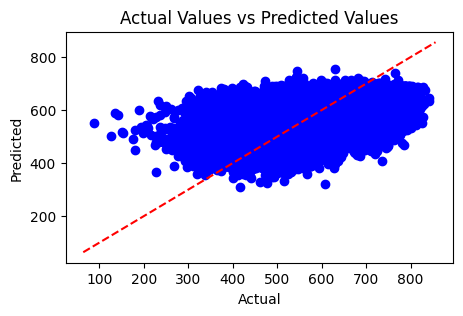

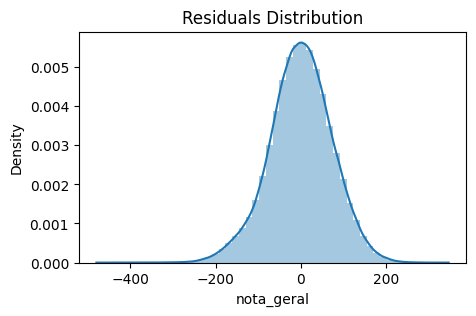

,Model,MAE,MAPE,RMSE,R2
Results,rf,57.8906,11.2618,73.6791,0.298


In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

esc_mae_mode = X_val['escolaridade_mae'].mode()[0]
esc_pai_mode = X_val['escolaridade_pai'].mode()[0]
X_val['escolaridade_mae'] = X_val['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_val['escolaridade_pai'] = X_val['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})
xtrainprep = preprocessor.fit_transform(X_train)
xvalprep = preprocessor.transform(X_val)
rf = RandomForestRegressor()
rf.fit(xtrainprep, y_train)
predtest = rf.predict(xvalprep)
evaluate_regressor(y_val, predtest, y_train, 'rf')

In [40]:
def evaluate_regressor(y_true, y_pred, y_train, model_name):
    '''
    Evaluates a regression model based on various metrics and plots.

    Args:
    y_true : The true target values.
    y_pred : The predicted target values.
    y_train : The actual target values from the training set.
    model_name (str): The name of the regression model.

    Returns:
    pandas.DataFrame: A dataframe containing the evaluation metrics.

    Raises:
    CustomException: An error occurred during the evaluation process.
    '''
    try:
        mae = round(mean_absolute_error(y_true, y_pred), 4)
        mse = round(mean_squared_error(y_true, y_pred), 4)
        rmse = round(np.sqrt(mse), 4)
        r2 = round(r2_score(y_true, y_pred), 4)
        mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 4)
        
        # Metrics
        print(f'Mean Absolute Error (MAE): {mae}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape}')
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'Root Mean Squared Error (RMSE): {rmse}')
        print(f'R-Squared (R2): {r2}')
        
        # Obtaining a dataframe of the metrics.
        df_results = pd.DataFrame({'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse, 'R2': r2}, index=['Results'])

        # Residual Plots
        
        # Analysing the results
        plt.figure(figsize=(5, 3))
        plt.title('Actual Values vs Predicted Values')
        plt.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()], 'r--')
        plt.scatter(y_true, y_pred, color='blue')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()
        
        # Distribution of the residuals
        plt.figure(figsize=(5, 3))
        sns.distplot((y_true - y_pred))
        plt.title('Residuals Distribution')
        plt.show()

        return df_results
    except:
        return

In [70]:
def compare_actual_predicted(y_true, y_pred):
    '''
    Compares actual and predicted values and calculates the residuals.

    Args:
    y_true : The true target values.
    y_pred : The predicted target values.

    Returns:
    pandas.DataFrame: A dataframe containing the actual, predicted, and residual values.

    Raises:
    CustomException: An error occurred during the comparison process.
    '''
    try:
        actual_pred_df = pd.DataFrame({'Actual': np.round(y_true, 2),
                                    'Predicted': np.round(y_pred, 2), 
                                    'Residual': np.round(np.abs(y_pred - y_true), 2)})
        return actual_pred_df
    except Exception as e:
        print()

In [75]:
df = compare_actual_predicted(y_val, predtest)
df.sample(100)

,Actual,Predicted,Residual
1888310,453.420013,626.72,173.30
997666,624.940002,565.75,59.19
1417052,387.220001,534.26,147.04
443908,520.000000,570.33,50.33
569024,446.320007,502.98,56.66
...,...,...,...
786646,572.640015,514.36,58.28
1350341,748.520020,649.18,99.34
1355392,550.900024,563.52,12.62
1968883,532.359985,570.31,37.95
